In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

import numpy as np
import pandas as pd

In [2]:
input_data = "./data/unirep_concat.csv"

In [3]:
data = pd.read_csv(input_data)
data.head()

,Sequence,Description,Ligand,Data,Units,Assay/Protocol,h_avg,h_final,c_final
0,MSEGEELFAGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,K1E+T7A+V53E+M231K,NaN,1.301,unitless,Brightness,"[0.00564064, -0.052851792, 0.0358626, -0.00721...","[0.0015191885, 0.2386941, 0.028036065, -0.0761...","[0.3461519, 1.2724495, 9.289647, -9.280799, 0...."
1,MSEGEELFAGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,K1E+T7A+M76L+M231T,NaN,3.702,unitless,Brightness,"[0.0056843236, -0.05248578, 0.03372663, -0.006...","[0.0020418263, 0.11393446, 0.029321756, -0.092...","[0.6894179, 0.57700205, 10.843222, -10.429447,..."
2,MSEGEELFAGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,K1E+T7A+N133D,NaN,3.689,unitless,Brightness,"[0.005524612, -0.05465085, 0.03441707, -0.0063...","[0.0007240173, -0.0018453612, 0.032945633, -0....","[0.6594968, -0.01064004, 10.861461, -11.253734..."
3,MSEGEELFPGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTPKF...,K1E+T7P+L42P+Y180N+T184S+A204T,NaN,1.301,unitless,Brightness,"[0.0053566922, -0.035990424, 0.029484132, -0.0...","[0.00034288465, 0.040698383, 0.021684002, -0.0...","[0.30741352, 0.26627296, 10.603406, -10.893406..."
4,MSEGEELFSGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,K1E+T7S+F98Y+K154R+E170G,NaN,3.647,unitless,Brightness,"[0.005479858, -0.057007894, 0.034597374, -0.00...","[0.00091315695, 0.026203262, 0.047493752, -0.0...","[0.7880522, 0.2115503, 10.409419, -10.637948, ..."


In [4]:
#should return 100 units
print(len(data.loc[0,"h_avg"]))

24942


In [5]:
#validate data for nans
print(data["Data"].isnull().sum())
#remove wierd addiitonal dataframe entries that appeared after preprocessing
data = data[data['Data'] > 1] 

0


In [6]:
# we select the feature vector and value that we want to train/predict upon
embeddings = data["h_avg"].to_numpy()
y = data["Data"].to_numpy()

# we select test data split
X_train, X_test, y_train, y_test = train_test_split(embeddings, y,random_state = 1, shuffle = True, 
                                                test_size=0.05)

# we convert each feature list to be a numpy array
def list_2_num(lst):
    num = [float(i) for i in lst]
    return num
    

X_train = np.array([np.array(list_2_num(xi[1:-1].split(","))) for xi in X_train])
X_test = np.array([np.array(list_2_num(xi[1:-1].split(","))) for xi in X_test])

In [7]:
#building model

#first normaliztion layer is created to push values between -1 and 1
#normalizer = preprocessing.Normalization(input_shape=[100,])
#normalizer.adapt(X_train)

normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
normalized_data = normalizer(X_train)

#next we build model with 5 hidden layers - [100,50,25,1]
model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=100, activation = "sigmoid"),
    layers.Dense(units=100, activation = "relu"),
    layers.Dense(units=50, activation = "relu"),
    layers.Dense(units=1)
])

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.0001),
    loss='mean_absolute_error', metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 1900)              3801      
_________________________________________________________________
dense (Dense)                (None, 100)               190100    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 209,102
Trainable params: 205,301
Non-trainable params: 3,801
_________________________________________________________________


In [8]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    verbose=1,
    validation_data = (X_test, y_test)
    
    #We make additional 20% validation split to calculate metrics during training
    #validation_split = 0.2
    )


Epoch 1/50
1536/1536 [==============================] - 2s 1ms/step - loss: 0.7906 - mae: 0.7906 - val_loss: 0.4103 - val_mae: 0.4103
Epoch 2/50
1536/1536 [==============================] - 2s 990us/step - loss: 0.3712 - mae: 0.3712 - val_loss: 0.3315 - val_mae: 0.3315
Epoch 3/50
1536/1536 [==============================] - 2s 981us/step - loss: 0.3142 - mae: 0.3142 - val_loss: 0.3053 - val_mae: 0.3053
Epoch 4/50
1536/1536 [==============================] - 2s 983us/step - loss: 0.2830 - mae: 0.2830 - val_loss: 0.2980 - val_mae: 0.2980
Epoch 5/50
1536/1536 [==============================] - 1s 965us/step - loss: 0.2673 - mae: 0.2673 - val_loss: 0.2737 - val_mae: 0.2737
Epoch 6/50
1536/1536 [==============================] - 1s 962us/step - loss: 0.2519 - mae: 0.2519 - val_loss: 0.2642 - val_mae: 0.2642
Epoch 7/50
1536/1536 [==============================] - 1s 972us/step - loss: 0.2400 - mae: 0.2400 - val_loss: 0.2512 - val_mae: 0.2512
Epoch 8/50
1536/1536 [============================

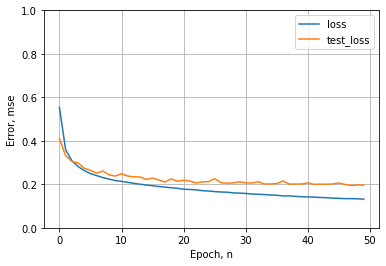

In [9]:
#validation results
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='test_loss')
    plt.ylim([0, 1])
    plt.xlabel('Epoch, n')
    plt.ylabel('Error, mse')
    plt.legend()
    plt.grid(True)

plot_loss(history)

Text(0, 0.5, 'Predicted flourescence values, (log)')

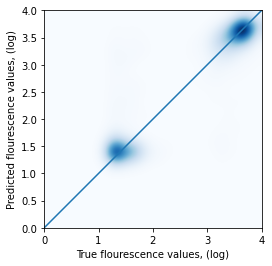

In [15]:
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter

test_predictions = model.predict(X_test).flatten()

# Generate some test data
x = y_test
y = test_predictions
lims = [0, 4.3]

heatmap, xedges, yedges = np.histogram2d(x, y, bins=1500, range = [[0, 4], [0, 4]], density = True)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
heatmap = gaussian_filter(heatmap, sigma=50)
#heatmap = np.log(heatmap+1)

plt.clf()
_ = plt.plot(lims, lims)
plt.imshow(heatmap.T, extent=extent, origin='lower', cmap = 'Blues' )
plt.xlabel('True flourescence values, (log)')
plt.ylabel('Predicted flourescence values, (log)')

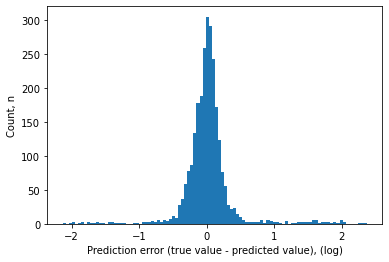

In [16]:
error = test_predictions - y_test
plt.hist(error, bins=100)
plt.xlabel('Prediction error (true value - predicted value), (log)')
_ = plt.ylabel('Count, n')

In [17]:
model.save("unirep_final")

INFO:tensorflow:Assets written to: unirep_final/assets
